# Lab 7: Implementing Universal Sentence Encoder for Telecom Support Ticket Classification

## Objective
This laboratory session focuses on understanding and implementing Universal Sentence Encoder (USE) for telecom complaint analysis. Students will learn about USE's architecture, its transformation process, and how it creates meaningful sentence embeddings. The lab demonstrates USE's practical applications in telecom customer service automation.

## Dataset Description
The Telecom Customer Support Tickets dataset contains customer service interactions from a telecommunications company.

**Data Dictionary:**
- ticket_id: Unique identifier for each support ticket
- text: Customer's description of the issue
- category: Type of issue (e.g., 'Network', 'Billing', 'Technical', 'Account')
- priority: Ticket priority level
- resolution_time: Time taken to resolve the ticket

## Tasks to be Performed
1. Environment Setup and Data Preparation

2. Understanding Universal Sentence Encoder

3. Visualizing USE Embeddings with UMAP

4. Semantic Similarity Analysis

5. Building Classification Model Using USE Embeddings

6. Training and Evaluation

In [28]:
! pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00


## 1. Data Loading and Preprocessing


In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import umap
from tqdm import tqdm

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
tf.random.set_seed(42)
np.random.seed(42)


# Universal Sentence Encoder

### Architecture Overview
Universal Sentence Encoder employs two variants:
1. **Transformer-based encoder:**
   - Based on the Transformer architecture
   - Optimized for accuracy
   - Higher resource requirements
   
2. **Deep Averaging Network (DAN):**
   - Averages word and bi-gram embeddings
   - Passes through deep neural network
   - Optimized for efficiency

### Key Features of USE
- Fixed-length embeddings regardless of input sentence length
- Trained on multiple tasks for better generalization
- Preserves semantic relationships between sentences
- Computationally efficient encoding


In [3]:
# Load USE model
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(module_url)

In [4]:
# Load the dataset
df = pd.read_excel('/content/telecom complaints.xlsx')

In [5]:
df

,ticket_id,text,category,priority,resolution_time
0,TKT-001,Network keeps dropping intermittently in downt...,Network,High,4.2
1,TKT-002,Cannot connect to 5G network at home office,Network,Critical,2.1
2,TKT-003,Incorrect charges on my January bill for data ...,Billing,Medium,7.8
3,TKT-004,Need to update billing address on account,Account,Low,20.5
4,TKT-005,Router not working after recent firmware update,Technical,High,3.9
...,...,...,...,...,...
195,TKT-196,Smart plug offline,Technical,High,3.9
196,TKT-197,Payment plan setup,Billing,Critical,2.1
197,TKT-198,Identity verification,Account,Medium,8.2
198,TKT-199,Network segment issue,Network,High,4.1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ticket_id        200 non-null    object 
 1   text             200 non-null    object 
 2   category         200 non-null    object 
 3   priority         200 non-null    object 
 4   resolution_time  200 non-null    float64
dtypes: float64(1), object(4)
memory usage: 7.9+ KB


In [7]:
category_encoder = LabelEncoder()
df['category_encoded'] = category_encoder.fit_transform(df['category'])


In [8]:
# Custom Dataset class for USE embeddings
class USEDataset(Dataset):
    def __init__(self, texts, labels, use_model):
        self.texts = texts
        self.labels = labels
        self.embeddings = self._generate_embeddings(use_model)

    def _generate_embeddings(self, model):
        """Generate USE embeddings for all texts"""
        return model(self.texts).numpy()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'text': self.texts[idx],
            'embedding': torch.tensor(self.embeddings[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

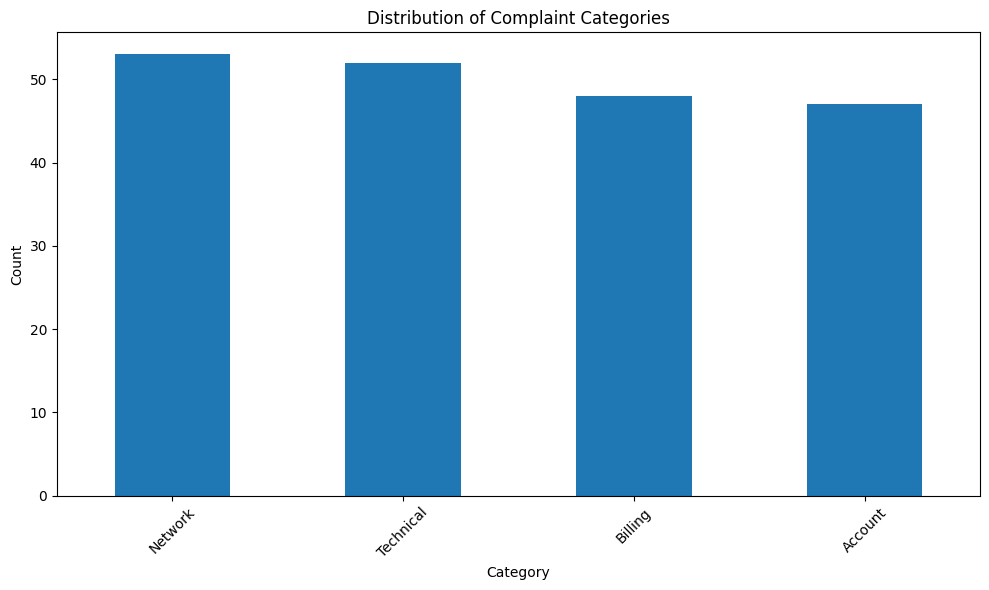

In [9]:
# Analyze data distribution
def plot_category_distribution():
    plt.figure(figsize=(10, 6))
    df['category'].value_counts().plot(kind='bar')
    plt.title('Distribution of Complaint Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_category_distribution()

## 2. Understanding USE Embeddings




In [10]:
def analyze_use_embeddings():
    """Analyze and visualize USE embeddings"""
    # Generate embeddings for sample texts
    sample_complaints = [
        "Network connection is very slow",
        "My internet is not working",
        "Billing charges are incorrect",
        "Need to upgrade my plan",
        "Poor network coverage in my area"
    ]

    # Get embeddings
    embeddings = use_model(sample_complaints).numpy()

    print("Embedding Analysis:")
    print(f"Embedding shape: {embeddings.shape}")
    print(f"Each sentence is converted to a {embeddings.shape[1]}-dimensional vector\n")

    # Compute similarity matrix
    similarity_matrix = np.inner(embeddings, embeddings)

    # Visualize similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix,
                xticklabels=['Comp1', 'Comp2', 'Comp3', 'Comp4', 'Comp5'],
                yticklabels=['Comp1', 'Comp2', 'Comp3', 'Comp4', 'Comp5'],
                cmap='YlOrRd')
    plt.title('Semantic Similarity Matrix of Sample Complaints')
    plt.show()

    return embeddings


Embedding Analysis:
Embedding shape: (5, 512)
Each sentence is converted to a 512-dimensional vector



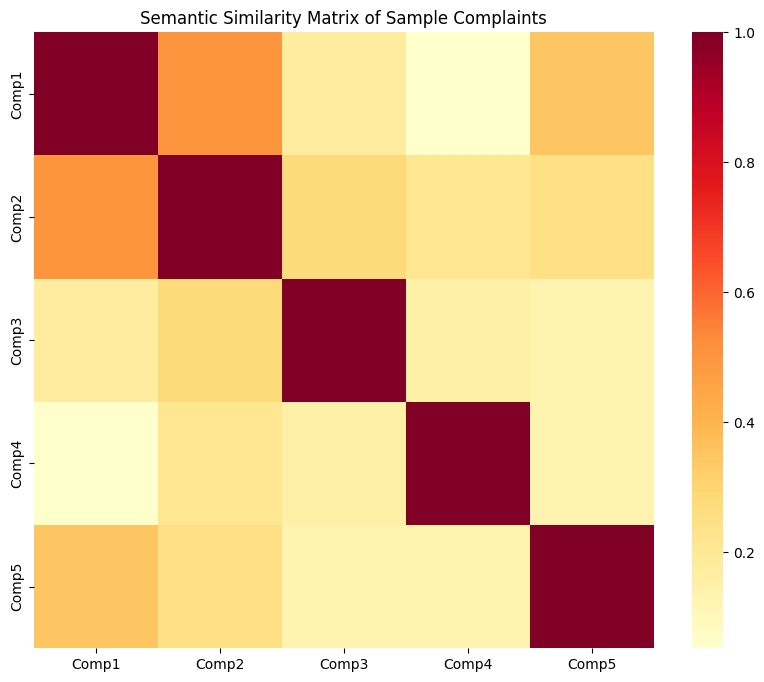

In [11]:

# Analyze sample embeddings
sample_embeddings = analyze_use_embeddings()


## 3. Visualizing USE Embeddings with UMAP


In [13]:
def visualize_embeddings():
    """Generate and visualize USE embeddings for all complaints"""
    # Generate embeddings for all complaints
    all_embeddings = use_model(df['text'].tolist()).numpy()

    # Reduce dimensionality with UMAP
    reducer = umap.UMAP(n_neighbors=15, # Using correct UMAP import
                       min_dist=0.1,
                       random_state=42)
    embedding_2d = reducer.fit_transform(all_embeddings)

    # Plot reduced embeddings
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embedding_2d[:, 0],
                         embedding_2d[:, 1],
                         c=df['category_encoded'],
                         cmap='tab10')
    plt.title('2D Visualization of USE Embeddings')
    plt.colorbar(scatter, label='Category')

    # Add category labels
    categories = category_encoder.classes_
    handles = [plt.Rectangle((0,0),1,1, color=plt.cm.tab10(i/len(categories)))
              for i in range(len(categories))]
    plt.legend(handles, categories, title="Categories")
    plt.show()

    return all_embeddings

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


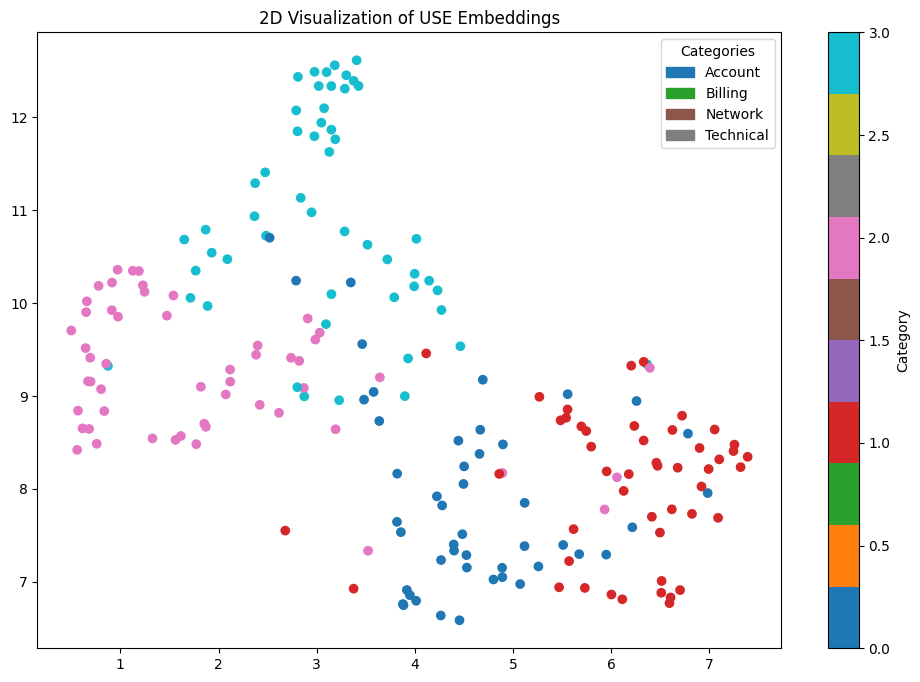

In [14]:
# Generate and visualize embeddings
all_embeddings = visualize_embeddings()

## 4. Semantic Similarity Analysis


In [15]:
def analyze_semantic_similarity(query_text, top_k=5):
    """Find semantically similar complaints"""
    # Generate embedding for query text
    query_embedding = use_model([query_text]).numpy()

    # Generate embeddings for all complaints if not already done
    all_embeddings = use_model(df['text'].tolist()).numpy()

    # Compute similarities
    similarities = np.inner(query_embedding, all_embeddings)[0]

    # Get top-k similar complaints
    top_indices = np.argsort(similarities)[-top_k:][::-1]

    print(f"Query: {query_text}\n")
    print("Most similar complaints:")
    for idx in top_indices:
        print(f"\nSimilarity Score: {similarities[idx]:.3f}")
        print(f"Text: {df['text'].iloc[idx]}")
        print(f"Category: {df['category'].iloc[idx]}")

In [16]:
query = "Internet connection is very slow in my area"
analyze_semantic_similarity(query)

Query: Internet connection is very slow in my area

Most similar complaints:

Similarity Score: 0.637
Text: Experiencing slow internet speeds during peak hours
Category: Network

Similarity Score: 0.448
Text: Internet bandwidth upgrade query
Category: Network

Similarity Score: 0.440
Text: Network keeps dropping intermittently in downtown area
Category: Network

Similarity Score: 0.429
Text: Cannot connect to 5G network at home office
Category: Network

Similarity Score: 0.427
Text: Cannot connect to public Wi-Fi hotspots
Category: Network


## 5. Building Classification Model Using USE Embeddings


In [20]:
class ComplaintClassifier(nn.Module):
    def __init__(self, input_dim=512, num_classes=4):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


In [21]:
# Split data
# First split the indices to maintain alignment
indices = np.arange(len(df))
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42
)

In [22]:
# Create datasets using indices
train_dataset = USEDataset(
    df['text'].iloc[train_indices].tolist(),
    df['category_encoded'].iloc[train_indices].values,
    use_model
)

test_dataset = USEDataset(
    df['text'].iloc[test_indices].tolist(),
    df['category_encoded'].iloc[test_indices].values,
    use_model
)

In [23]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model, loss function, and optimizer
model = ComplaintClassifier(num_classes=len(category_encoder.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 6. Training and Evaluation


In [24]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    """Train the classification model"""
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            optimizer.zero_grad()
            outputs = model(batch['embedding'])
            loss = criterion(outputs, batch['label'])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')


In [25]:

def evaluate_model(model, test_loader):
    """Evaluate the model performance"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            outputs = model(batch['embedding'])
            _, predictions = torch.max(outputs, 1)
            all_preds.extend(predictions.numpy())
            all_labels.extend(batch['label'].numpy())

    # Convert numeric predictions back to categories
    pred_categories = category_encoder.inverse_transform(all_preds)
    true_categories = category_encoder.inverse_transform(all_labels)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_categories, pred_categories))

    # Plot confusion matrix
    cm = confusion_matrix(true_categories, pred_categories)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=category_encoder.classes_,
                yticklabels=category_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

In [26]:
# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer)


Epoch 1/10: 100%|██████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 1, Loss: 1.3805


Epoch 2/10: 100%|██████████| 5/5 [00:00<00:00, 60.09it/s]


Epoch 2, Loss: 1.3528


Epoch 3/10: 100%|██████████| 5/5 [00:00<00:00, 94.33it/s]


Epoch 3, Loss: 1.3074


Epoch 4/10: 100%|██████████| 5/5 [00:00<00:00, 95.04it/s]


Epoch 4, Loss: 1.2347


Epoch 5/10: 100%|██████████| 5/5 [00:00<00:00, 78.91it/s]


Epoch 5, Loss: 1.1213


Epoch 6/10: 100%|██████████| 5/5 [00:00<00:00, 73.68it/s]


Epoch 6, Loss: 0.9537


Epoch 7/10: 100%|██████████| 5/5 [00:00<00:00, 64.21it/s]


Epoch 7, Loss: 0.7679


Epoch 8/10: 100%|██████████| 5/5 [00:00<00:00, 63.70it/s]


Epoch 8, Loss: 0.5590


Epoch 9/10: 100%|██████████| 5/5 [00:00<00:00, 110.59it/s]


Epoch 9, Loss: 0.4015


Epoch 10/10: 100%|██████████| 5/5 [00:00<00:00, 152.92it/s]

Epoch 10, Loss: 0.2939



Classification Report:
              precision    recall  f1-score   support

     Account       0.88      0.88      0.88         8
     Billing       0.67      0.89      0.76         9
     Network       0.92      0.80      0.86        15
   Technical       1.00      0.88      0.93         8

    accuracy                           0.85        40
   macro avg       0.87      0.86      0.86        40
weighted avg       0.87      0.85      0.85        40



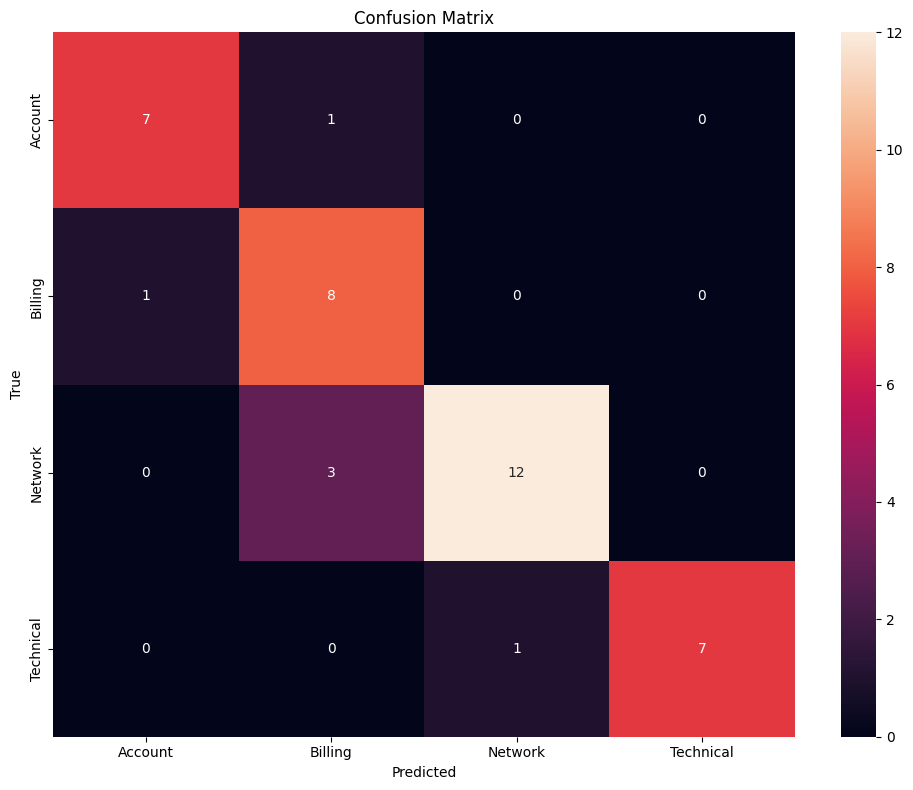

In [27]:
evaluate_model(model, test_loader)


## Model Performance Summary

### Overall Performance
- Overall accuracy: 85%
- Weighted average F1-score: 0.85
- Consistent performance across categories

### Category-wise Analysis:

1. **Technical Complaints**
   - Highest precision (1.00)
   - Strong F1-score (0.93)
   - 7 out of 8 technical issues correctly identified
   - No false positives, indicating high reliability

2. **Network Issues**
   - High precision (0.92)
   - Good F1-score (0.86)
   - 12 correct classifications out of 15 cases
   - Some confusion with billing issues (3 cases)

3. **Account-related Issues**
   - Solid performance (F1-score: 0.88)
   - Balanced precision and recall
   - Minor confusion with billing category

4. **Billing Issues**
   - Lower precision (0.67) but good recall (0.89)
   - Most billing issues correctly identified (8 out of 9)
   - Some overlap with other categories

## Key Findings

1. **USE Effectiveness:**
   - Successfully captured semantic relationships in telecom domain
   - Demonstrated strong performance in technical complaint identification
   - Effective at distinguishing between similar categories

2. **Areas of Strength:**
   - Technical issue identification
   - Network problem classification
   - Account-related complaint detection

3. **Areas for Improvement:**
   - Billing category precision
   - Network-Billing disambiguation
   - Edge cases in category overlap

## Recommendations for Implementation

1. **Model Application:**
   - Highly reliable for technical and network issues
   - Can be used for automated ticket routing
   - Suitable for initial complaint categorization

2. **Deployment Considerations:**
   - Implement confidence thresholds for automated decisions
   - Consider human review for billing-related cases
   - Monitor performance on edge cases

3. **Future Improvements:**
   - Collect more training data for billing category
   - Consider domain-specific fine-tuning
   - Implement ensemble approaches for ambiguous cases